## **Gradient Boosting (GBM)**
Today gradient boosting machine is one of the main production solutions when working with tabular heterogeneous data because it has high performance and accuracy or to be more precise, its modifications which will be discussed later.

As in the case of Adaboost gradient boosting adds basic models to the ensemble sequentially, however, instead of training models with weights based on the errors of their predecessors in this case the models are trained on residual errors made by previous models.

### **The principle of operation of gradient boosting for regression**
The algorithm is constructed as follows:
- 1) the initial prediction is assigned the average value of y_train for all samples;
- 2) the residuals of the model are calculated based on the anti-gradient of the loss function;
- 3) the regression tree is trained on X_train and residuals, then a prediction is made on X_train;
- 4) the resulting prediction is added to the original one and steps 2-4 are repeated for each tree;
- 5) after training all models, the initial prediction from step 1 is created again;
- 6) next, predictions are made for X_test on trained trees and added to the initial one;
- 7) the amount received will be the final prediction.

**Formulas for calculations**

$L(y_i, F(x_i)) = \frac{1}{2} (y_i - F(x_i))^2 \ - \ $ loss function

$r_{ik} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_
{F(x) = F_{m-1}(x)} = y_{i} - F_{m-1}(x_i) \ - \ $ residuals

### **The principle of operation of gradient boosting for classification**
In the case of classification things are a little more complicated: one-hot encoding must be applied to each unique class and translated into probabilities using a softmax function and a $\gamma$ coefficient must be added to tree predictions which regulates the degree of contribution of each new tree to the overall model to reduce overfitting. Also the quality of gradient boosting predictions can be significantly improved by applying the K-class LogitBoost concept: weights are calculated for each tree and only then the residuals are based on them.

The algorithm is constructed as follows:
- 1) one-hot encoding is used for y_train and the initial prediction is assigned values of 0 for each class;
- 2) predictions are converted into probabilities using the softmax function;
- 3) the residuals of the model are calculated based on the anti-gradient of the loss function and probabilities (as well as the weight in the case of LogitBoost);
- 4) the regression tree is trained on X_train and residuals (and in the case of LogitBoost, weights are also assigned), then a prediction is made on X_train;
- 5) for each leaf in the tree the coefficients $\gamma$ are calculated based on the residuals taken from the positions of observations that fell into a certain leaf node;
- 6) the obtained predictions for each class and the sum of the coefficients $\gamma$ are added to the initial ones;
- 7) steps 2-6 are repeated for each tree in each class;
- 8) after training all models an initial prediction is created from step 1;
- 9) next, predictions are made for X_test on trained trees for each class and added to the initial ones;
- 10) classes with the maximum amount will be the final prediction.

**Formulas for calculations**

$L(\{y_k, F_k(x)\}_{1}^{K}) = -\sum\limits_{k=1}^{K} y_k \ log \ p_k(x) \ - \ $ loss function

$p_k(x) = softmax(F_k(x)) = \frac{e^{F_k(x)}}{\sum\limits_{l=1}^{K} e^{F_l(x)}} \ - \ $ probability of each class

$r_{ik} = -\left[\frac{\partial L(\{y_{il}, F_l(x_i)\}_{l=1}^{K})}{\partial F_k(x_i)}\right]_
{\{F_l(x) = F_{l,m-1}(x)\}_{1}^{K}} = y_{ik} - p_{k,m-1}(x_i) \ - \ $ residuals

$\gamma_{jkm} = \frac{K-1}{K} \frac{\sum_{x_i \in R_{jkm}} r_{ik}}
{\sum_{x_i \in R_{jkm}} |r_{ik}| (1 - |r_{ik}|)}$

$w_k(x_i) = p_k(x_i) (1 - p_k(x_i)) \ - \ $ weigts for K-class LogitBoost

$r_{ik} = \frac{K-1}{K} \frac{y_{ik} - p_k(x_i)}{w_k(x_i)} \ - \ $ residuals for K-class LogitBoost

### **Python implementation from scratch**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from mlxtend.plotting import plot_decision_regions

In [2]:
class GBMClassifier:
    def __init__(self, logitboost=False, learning_rate=0.1, n_estimators=100,
                 max_depth=3, random_state=0):
        self.logitboost = logitboost
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state

    def _softmax(self, predictions):
        exp = np.exp(predictions)

        return exp / np.sum(exp, axis=1, keepdims=True)

    def _compute_gammas(self, residuals, leaf_indexes, eps=1e-4):
        gammas = []

        for j in np.unique(leaf_indexes):
            x_i = np.where(leaf_indexes == j)
            numerator = np.sum(residuals[x_i])
            norm_residuals_xi = np.linalg.norm(residuals[x_i]) + eps
            denominator = np.sum(norm_residuals_xi * (1 - norm_residuals_xi))
            gamma = (self.K - 1) / self.K * numerator / denominator
            gammas.append(gamma)

        return gammas

    def fit(self, X, y):
        self.K = len(np.unique(y))
        self.trees = {k: [] for k in range(self.K)}
        one_hot_y = pd.get_dummies(y).to_numpy()   # one-hot encoding
        predictions = np.zeros(one_hot_y.shape)

        for _ in range(self.n_estimators):
            probabilities = self._softmax(predictions)

            for k in range(self.K):
                if self.logitboost:   # based on K-class LogitBoost
                    numerator = (one_hot_y.T[k] - probabilities.T[k])
                    denominator = probabilities.T[k] * (1 - probabilities.T[k])
                    residuals = (self.K - 1) / self.K * numerator / denominator
                    weights = denominator
                else:
                    residuals = one_hot_y.T[k] - probabilities.T[k]
                    weights = None

                tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth,
                                             random_state=self.random_state)
                tree.fit(X, residuals, sample_weight=weights)
                self.trees[k].append(tree)

                leaf_indexes = tree.apply(X)
                gammas = [] if self.logitboost else self._compute_gammas(residuals, leaf_indexes)
                predictions.T[k] += self.learning_rate * tree.predict(X) + np.sum(gammas)

    def predict(self, samples):
        predictions = np.zeros((len(samples), self.K))

        for i in range(self.n_estimators):
            for k in range(self.K):
                predictions.T[k] += self.learning_rate * self.trees[k][i].predict(samples)

        return np.argmax(predictions, axis=1)

In [3]:
class GBMRegressor:
    def __init__(self, learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        self.initial_leaf = y.mean()
        predictions = np.zeros(len(y)) + self.initial_leaf

        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth,
                                         random_state=self.random_state)
            tree.fit(X, residuals)
            predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

    def predict(self, samples):
        predictions = np.zeros(len(samples)) + self.initial_leaf

        for i in range(self.n_estimators):
            predictions += self.learning_rate * self.trees[i].predict(samples)

        return predictions

In [4]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Glass Classification](https://www.kaggle.com/datasets/uciml/glass) dataset will be used to train models, where it is necessary to correctly determine the type of glass by its characteristics. In the case of regression, Diabetes dataset from scikit-learn is used.

**The data below will be used in the examples for all modifications of gradient boosting**.

In [5]:
df_path = "/content/drive/MyDrive/glass.csv"
glass_df = pd.read_csv(df_path)
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [6]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Model training and evaluation of the obtained results**  
In the case of classification the manual implementation differs slightly in terms of accuracy from scikit-learn. This is due to the fact that the latter uses a more sophisticated approach for predicting and calculating residuals, but the essence remains the same and in most cases it works about the same as the manual implementation, especially in comparison with the LogitBoost modification.

In the case of regression the error in manual implementation is even slightly lower than in scikit-learn — the differences are insignificant.

It is also worth noting that scikit-learn has a special version of gradient boosting — HistGradientBoosting based on LightGBM, designed to work with large datasets which performs much faster and more often better than classic gradient boosting.

The results are shown below.

**GBMClassifier**

In [7]:
gbc = GBMClassifier(random_state=0)
gbc.fit(X1_train, y1_train)
gbc_pred_res = gbc.predict(X1_test)
gbc_accuracy = accuracy_score(y1_test, gbc_pred_res)
print(f'gbc accuracy: {gbc_accuracy}')
print(gbc_pred_res)

gbc accuracy: 0.6111111111111112
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 1 1 5 0 5 5 1 0 5 0 1 0 0 4 1 0 0 0 0
 0 0 5 1 4 1 0 0 1 0 1 0 1 0 3 5 0]


**GBMClassifier with LogitBoost concept**

In [8]:
logit_bc = GBMClassifier(logitboost=True, random_state=0)
logit_bc.fit(X1_train, y1_train)
logit_bc_pred_res = logit_bc.predict(X1_test)
logit_bc_accuracy = accuracy_score(y1_test, logit_bc_pred_res)
print(f'logit_gbc accuracy: {logit_bc_accuracy}')
print(logit_bc_pred_res)

logit_gbc accuracy: 0.6666666666666666
[5 0 1 4 1 1 0 1 1 1 1 0 0 1 1 5 2 1 1 0 3 0 5 1 2 0 5 0 0 1 0 0 1 0 0 0 0
 2 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]


**GradientBoostingClassifier (scikit-learn)**

sk_gbc accuracy: 0.6666666666666666
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 2 1 2 0 1 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 1 1 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


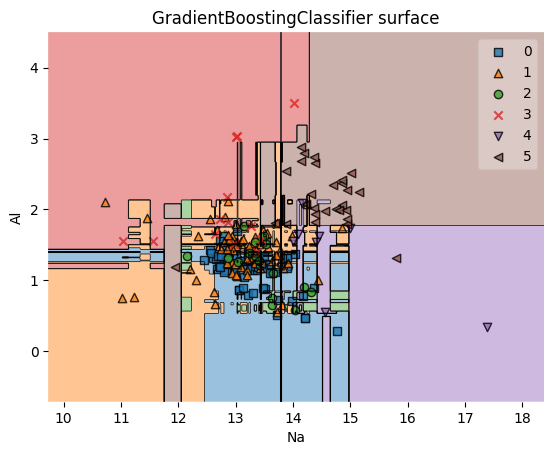

In [9]:
sk_gbc = GradientBoostingClassifier(random_state=0)
sk_gbc.fit(X1_train, y1_train)
sk_gbc_pred_res = sk_gbc.predict(X1_test)
sk_gbc_accuracy = accuracy_score(y1_test, sk_gbc_pred_res)
print(f'sk_gbc accuracy: {sk_gbc_accuracy}')
print(sk_gbc_pred_res)

feature_indexes = [1, 3]
title1 = 'GradientBoostingClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_gbc, feature_indexes, title1)

**HistGradientBoostingClassifier (scikit-learn)**

sk_hist_gbc accuracy: 0.7407407407407407
[5 0 1 4 1 1 0 1 1 1 0 1 0 1 1 5 2 1 0 2 3 0 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 2 0 5 1 4 1 0 0 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


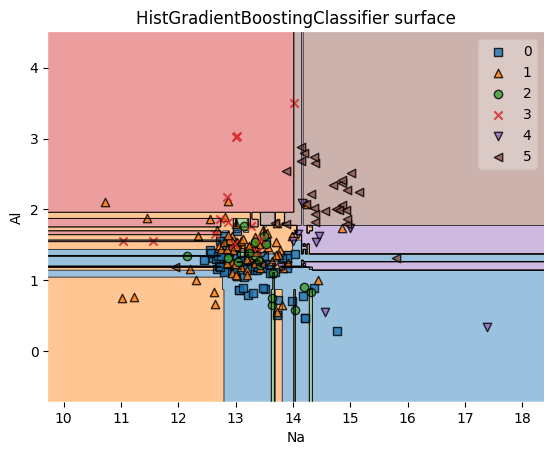

In [10]:
sk_hist_gbc = HistGradientBoostingClassifier(random_state=0)
sk_hist_gbc.fit(X1_train, y1_train)
sk_hist_gbc_pred_res = sk_hist_gbc.predict(X1_test)
sk_hist_gbc_accuracy = accuracy_score(y1_test, sk_hist_gbc_pred_res)
print(f'sk_hist_gbc accuracy: {sk_hist_gbc_accuracy}')
print(sk_hist_gbc_pred_res)

feature_indexes = [1, 3]
title2 = 'HistGradientBoostingClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_hist_gbc, feature_indexes, title2)

**GBMRegressor**

In [11]:
gbr = GBMRegressor(random_state=0)
gbr.fit(X2_train, y2_train)
gbr_pred_res = gbr.predict(X2_test)
mape = mean_absolute_percentage_error(y2_test, gbr_pred_res)
print(f'gbr mape: {mape}')
print(gbr_pred_res)

gbr mape: 0.399913339601999
[255.26058697 236.87383554 189.22369747 111.4291292  195.31958776
 249.2293251   97.46956406 205.91110801 133.47952304 240.88679883
 187.19018483 171.09963906 132.63933991  86.28964353 286.56077589
 105.78347251 161.94686043  72.58069452 105.92470096 236.52718059
 178.31146418 127.93036968 164.16563703 147.68681371 229.72747212
 194.16656023 142.44300193  68.79177464 237.21638657 163.36730299
 228.0338107   85.82843049 122.42781509 153.99332065 133.44848601
 159.00754731 151.98981608 147.1238119   88.56372077 200.84785209
 111.32129613 157.60108633 137.94395538 173.39402287 176.29284757
  62.85019316 109.646804   124.14982054  83.45697583 266.40618239
 141.2307366   42.05033124 163.57898214 149.92213387 230.37326368
 226.98842404 176.95426024 128.73302071  94.7641018  180.13853236
 242.31821245 147.52903035 130.45931832  97.32617479 246.70709949
 155.26338705  88.36785447 243.39330218 215.93042351  57.89243255
  87.76236479 138.21222825 101.23449416 140.8052

**GradientBoostingRegressor (scikit-learn)**

In [12]:
sk_gbr = GradientBoostingRegressor(random_state=0)
sk_gbr.fit(X2_train, y2_train)
sk_gbr_pred_res = sk_gbr.predict(X2_test)
sk_mape = mean_absolute_percentage_error(y2_test, sk_gbr_pred_res)
print(f'sk_gbr mape: {sk_mape}')
print(sk_gbr_pred_res)

sk_gbr mape: 0.4010647096251489
[255.26058697 236.87383554 189.22369747 111.4291292  195.31958776
 249.2293251   97.46956406 205.91110801 133.47952304 240.88679883
 187.19018483 171.09963906 132.63933991  86.28964353 286.56077589
 105.78347251 161.94686043  72.58069452 105.92470096 236.52718059
 182.08417504 127.93036968 164.16563703 147.68681371 229.72747212
 194.16656023 142.44300193  68.79177464 237.21638657 163.36730299
 223.14955275  85.82843049 122.42781509 153.99332065 133.44848601
 159.00754731 151.98981608 147.1238119   88.56372077 200.84785209
 117.71059889 157.60108633 137.94395538 173.39402287 176.29284757
  62.85019316 109.646804   124.14982054  83.45697583 266.40618239
 141.2307366   42.05033124 163.57898214 149.92213387 230.37326368
 226.98842404 176.95426024 128.73302071  94.7641018  180.13853236
 242.31821245 147.52903035 131.71442058  97.32617479 246.70709949
 155.26338705  88.36785447 243.39330218 215.93042351  54.04270734
  87.76236479 138.21222825 101.23449416 140.

**HistGradientBoostingRegressor (scikit-learn)**

In [13]:
sk_hist_gbr = HistGradientBoostingRegressor(random_state=0)
sk_hist_gbr.fit(X2_train, y2_train)
sk_hist_gbr_pred_res = sk_hist_gbr.predict(X2_test)
sk_hist_mape = mean_absolute_percentage_error(y2_test, sk_hist_gbr_pred_res)
print(f'sk_hist_gbr mape: {sk_hist_mape}')
print(sk_hist_gbr_pred_res)

sk_hist_gbr mape: 0.39301688868165796
[264.59007545 243.59190524 180.62442773 108.53165744 195.17695513
 258.1710931  112.67894454 239.18006052 144.50027011 244.02461776
 180.19087697 171.2628973  142.6966707   94.26236013 301.44493762
  90.25622203 154.82566511  75.43291346  96.36987316 230.14565012
 196.50928346 134.41863815 167.28719774 118.51218378 209.75431111
 176.46248808 113.40188129  68.47515467 248.57638999 116.15751993
 195.54397416  59.94733366 153.03012884 165.84819847 135.95402508
 133.54279177 190.26058998 153.08963938  86.65214731 185.07312005
 110.00197459 142.99434304 111.32566034 205.63519803 163.76035901
  68.26003406 118.15074567 101.01137587  57.54356002 247.29839792
 140.32714196  41.87878548 149.89720974 189.08931404 251.48016218
 175.76119949 160.38118455 110.76716142 107.00114228 154.75409577
 256.3194536  148.8935956  119.32752592  78.65118163 252.18315433
 122.833807    92.10033912 219.56310647 199.35553751  87.27114699
  78.83529151 114.14943246  86.0743350

### **Pros and cons of Gradient Boosting (GBM)**
Pros:
- high accuracy;
- works well with heterogeneous data;
- it's the basis of other modifications of gradient boosting.

Cons:
- low training speed when working with large datasets;
- lack of ability to work with categorical features;
- the possibility of overfitting due to poor data preprocessing.

It is worth noting that the above disadvantages have been partially or completely eliminated in the modifications of gradient boosting which will be discussed now.

### **Additional sources**
Paper «Greedy Function Approximation: A Gradient Boosting Machine», Jerome H. Friedman.

Documentation:
- [Gradient Boosting description](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees);
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html);
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html);
- [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html);
- [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

Lectures:
- [one](https://www.youtube.com/watch?v=-b6Y1DDxvL4&t=3271s&ab_channel=ComputerScienceCenter);
- [two](https://www.youtube.com/watch?v=V_-BSY7hLC0&list=PLgaemU2xZlTgJhfBHnolmS-8WwsFifnFn&index=11&ab_channel=meanxai);
- [three](https://www.youtube.com/watch?v=wPqtzj5VZus&ab_channel=H2O.ai).

Step-by-step construction of Gradient Boosting:
- [one](https://www.youtube.com/watch?v=3CC4N4z3GJc&ab_channel=StatQuestwithJoshStarmer);
- [two](https://www.youtube.com/watch?v=2xudPOBz-vs&t=981s&ab_channel=StatQuestwithJoshStarmer);
- [three](https://www.youtube.com/watch?v=jxuNLH5dXCs&t=2s&ab_channel=StatQuestwithJoshStarmer);
- [four](https://www.youtube.com/watch?v=StWY5QWMXCw&t=1942s&ab_channel=StatQuestwithJoshStarmer).

## **XGBoost features**
XGBoost (Extreme Gradient Boosting) is perhaps the most popular modification of gradient boosting to date with which many Kaggle competitions have been won. Let's look at the reasons why this happened.

Unlike GBM in XGBoost the initial prediction of the regression tree is set to $f_0(x) = 0.5$ and instead of stumps with a depth of 3 deeper trees with leaves in the range from 8 to 32 are taken in both the case of regression and classification, and regularization is added to the loss function (L1 or L2 to choose from) which penalizes a tree with a high sum of the norm of values in the leaves. This sum is represented as an objective function, the calculation of the values of which is approximated by a Taylor series expansion of the 2nd order.

$Obj^{\ t} = \sum\limits_{i=1}^{N} L(y_i, \hat{y_i}^{(t-1)} + f_t(x_i)) + \Omega(f_t) \ - \ $ objective function

$\Omega(f_t) = \gamma \ T + \frac{1}{2} \lambda||w||^2 \ - \ $ L2-regularization

$Obj^{\ t} \approx \sum\limits_{i=1}^{N} [L(y_i, \hat{y_i}^{(t-1)}) + g_i f_t(x_i) +
\frac{1}{2} h_i f_t^2(x_i) ] + \gamma \ T + \frac{1}{2} \lambda \sum\limits_{j=1}^{T} w_j^2 = $ \\
$\ \ \ \ \ \ \ \
= \sum\limits_{j=1}^{T} [(\sum\limits_{i \in I_j}g_i) w_j + \frac{1}{2} (\sum\limits_{i \in I_j}h_i + \lambda) w_j^2 ] + \gamma \ T \ - \ $ second-order Taylor approximation of objective function \\

$g_i \ - \ $ first order gradient

$h_i \ - \ $ second order gradient (hessian)

$ \gamma, \lambda \ - \ $ regularization parameters

The second-order approximation is computationally convenient, since most of the terms are the same at each individual iteration and most of the expression can be calculated once and reused as a constant for all other partitions and in this case the only things left to calculate are $f_t(x_i)$ and $\Omega(f_t)$.

The optimal weight value of the j-th leaf node in the tree is calculated as follows:

$$Obj^{\ t} = -\frac{1}{2} \sum\limits_{j=1}^{T} \frac{(\sum_{i \in I_j} g_i)^2}{\sum_{i \in I_j} h_i + \lambda} + \gamma \ T$$

The lower this value, the better the tree structure is.

Since enumerating all possible tree structures and choosing the best one is very complicated, we can optimize this task by adding one tree node partition at a time. In particular we iteratively add branches to the tree using a greedy algorithm and the information gain will look like this:

$$gain = \frac{1}{2} \left[\frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} -
\frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda} \right] - \gamma $$

The information gain will show a change in the purity of the node after splitting it. Its maximum value will correspond to the best threshold value (splitting criterion) of the node in the tree.

It is also worth mentioning that XGBoost supports the selection of linear models as the base ones but in general they work worse than trees.

### **Additional optimizations in XGBoost**

**Weighted quantile sketch**

When working with large datasets, XGBoost uses an approximate greedy algorithm. This means that instead of testing all possible thresholds we test only quantiles. Using parallelization to split the dataset and create branches in each tree independently so that multiple cores can work with them simultaneously, the weighted quantile sketch algorithm combines the data into an approximate histogram divided into weighted quantiles which place observations with low confidence predictions in quantiles with fewer observations.

**Cache-aware access & out-of-core computing**

For faster calculation of predictions, gradients and hessians are stored in cache memory (cache-aware access) and in the case of large datasets, when there is not enough cache and RAM memory from the hard disk is used. Given that reading data on the hard disk is much slower than in cache memory, compression is performed for accelerated processing. Data is stored in memory units called blocks, information in which is stored in the format of compressed columns sorted by appropriate values in parallel using all available CPU cores and each block is decompressed in an independent stream when loaded into memory. This technique is called "out-of-core computing". If there are several hard drives, parallel block segmentation is applied for each hard drive (sharding).

When using compressed data it must be borne in mind that the compression and decompression process takes additional time, so choosing a compression algorithm (lossy and without) and its parameters may affect overall performance but it is still much faster to read without compression.

**Sparsity-aware split finding**

XGBoost also supports working with skips. The main idea is next: observations with skips are removed from the original dataset and presented as a separate dataset. After building a tree for observations without skips, their residues are calculated, then the residues for observations with skips are added to the remnants of the tree for both the left and right nodes. In the end, the information gain is calculated for each node in the tree: a threshold is selected for splitting with the maximum gain. This technique is called sparsity-aware split finding.

**GPU training**

To speed up the training process GPU support is implemented in XGBoost using the device="cuda" and tree_method="gpu_hist" parameters. It is also worth noting that this algorithm supports fully distributed GPU training using Dask, Spark and PySpark.

### **Package implementation of XGBoost and evaluation of the obtained results**
Due to the above optimizations and features XGBoost works better than the classical implementation, as can be seen in the example of classification, but the result was worse in this case using the example of regression. If you prepare the data well and experiment with setting up hyperparameters, XGBoost will work much better both in the case of regression and classification.

**XGBClassifier**

xgbc accuracy: 0.6851851851851852
[5 0 1 4 1 1 0 1 1 1 3 0 1 1 1 5 2 1 1 2 3 0 5 5 0 0 5 0 0 1 0 0 1 0 0 0 0
 0 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


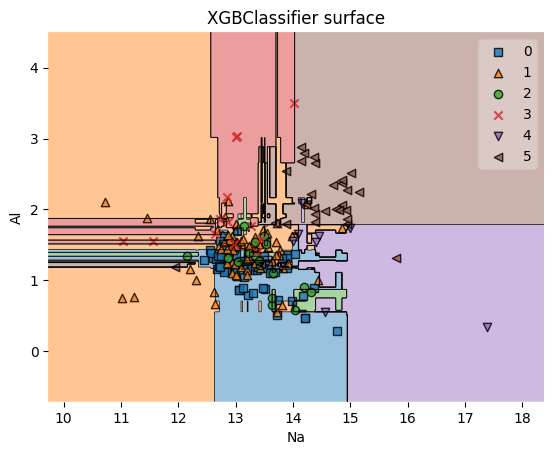

In [14]:
from xgboost import XGBClassifier, XGBRegressor

xgbc = XGBClassifier(seed=0)
xgbc.fit(X1_train, y1_train)
xgbc_pred_res = xgbc.predict(X1_test)
xgbc_accuracy = accuracy_score(y1_test, xgbc_pred_res)
print(f'xgbc accuracy: {xgbc_accuracy}')
print(xgbc_pred_res)

feature_indexes = [1, 3]
title2 = 'XGBClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, xgbc, feature_indexes, title2)

**XGBRegressor**

In [15]:
xgbr = XGBRegressor(seed=0)
xgbr.fit(X2_train, y2_train)
xgbr_pred_res = xgbr.predict(X2_test)
xgbr_mape = mean_absolute_percentage_error(y2_test, xgbr_pred_res)
print(f'xgbr mape: {xgbr_mape}')
print(xgbr_pred_res)

xgbr mape: 0.4341167858276216
[281.3304   241.21165  212.13124  136.89372  144.54208  261.7871
 125.257454 236.16089  199.79964  250.18103  188.50882  126.724464
 161.2112    73.98386  302.50272   97.35103  160.85774   67.10394
  96.0406   284.72873  181.48717  117.764626 182.91393  127.76686
 229.30229  173.58592  170.03932   76.73085  240.7698   117.70699
 224.36049   63.628925 124.27327  142.07358  173.09418  139.11557
 163.61208   92.8561    95.91142  217.65016  112.03522  122.800545
 110.06953  181.34201  159.39062   61.97588  114.534805 145.20259
  84.905815 284.77567  195.29976   45.550606  92.54941  180.4689
 279.12097  241.1343   177.77785  130.43887  159.53189  158.2313
 253.25339  181.86093  120.71679   90.604706 274.5059   140.21674
  92.80314  211.71936  233.20622  110.791824  67.89235  133.62137
 123.05923  102.70884  167.2115   159.32262  131.7305   243.41493
 254.97531  210.0554   130.00981  222.21094   52.864147 251.23187
 118.602684  87.89112  121.147095 218.15724   9

### **Pros and cons of XGBoost**

Pros:
- relatively high training speed and accuracy of predictions;
- the ability to work with skips;
- flexibility in configuration due to the large number of hyperparameters.

Cons:
- complexity in configuration due to the large number of hyperparameters;
- at the moment there is no full-fledged (experimental) ability to work with categorical features which can greatly reduce performance when encoding large amounts of data.

### **Additional sources**

Paper «XGBoost: A Scalable Tree Boosting System», Tianqi Chen, Carlos Guestrin.

[Documentation](https://xgboost.readthedocs.io/en/stable/index.html).

Lectures:
- [one](https://www.youtube.com/watch?v=CCDIbNGGBwY&t=638s&ab_channel=ComputerScienceCenter);
- [two](https://www.youtube.com/watch?v=Vly8xGnNiWs&t=4168s&ab_channel=RealDataScienceUSA%28formerlyDataScience.LA%29).

Step-by-step construction of XGBoost:
- [one](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=17&ab_channel=StatQuestwithJoshStarmer);
- [two](https://www.youtube.com/watch?v=8b1JEDvenQU&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=17&ab_channel=StatQuestwithJoshStarmer);
- [three](https://www.youtube.com/watch?v=ZVFeW798-2I&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=18&ab_channel=StatQuestwithJoshStarmer);
- [four](https://www.youtube.com/watch?v=oRrKeUCEbq8&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=19&ab_channel=StatQuestwithJoshStarmer).

## **CatBoost features**
CatBoost (Categorical Boosting) is a more efficient implementation of gradient boosting from Yandex, the feature of which is the ability to work with categorical features without preprocessing. Let's take a closer look at how this happens.

### **Ordered target (CatBoost) encoding**
When encoding categorical features one of several classical approaches is applied to boostings:
- target encoding;
- one-hot encoding (works well only if the attributes contain a small number of values);
- feature hashing into several buckets (the source data is converted into a unique sequence of characters (hash values), which are divided into groups (buckets) and processed in parallel with the subsequent application of target or one-hot encoding);
- mean target encoding (a new value for the current categorical feature is calculated as the average value of the target variable according to the dataset);
- leave-one-out (the average value of the target variable is calculated for all objects except the current one);
- leave-bucket-out (the average value of the target variable is calculated on one part of the data and applied to the remaining others);

However, all of the above methods somehow lead to data leakage and overfitting and this problem can be partially solved by using *mean target encoding* on a deferred sample, which works noticeably better but this method is not ideal since there is less data left for training and calculating statistics on categorical features.

CatBoost uses a modified approach to mean target encoding called *Ordered target (CatBoost) encoding*, which consists of 3 steps listed below.

**Random permutation**

The samples in the dataset are shuffled randomly, which allows you to create a more balanced dataset and reduce overfitting.

**Statistics "on the past"**

After a random permutation, a new value is calculated for the current categorical feature as follows: $$CTR = \frac{targetSum + Prior}{totalCount + 1}$$

$Prior$ is a constant defined as the arithmetic mean of the target values.

$targetSum$ is the sum of the target values for a specific categorical feature up to the current moment.

$totalCount$ — the number of all observations for a specific categorical feature up to the current moment.

This formula is applicable for both regression and multiclassication cases.

**Step-by-step example from scratch for multiclassification**

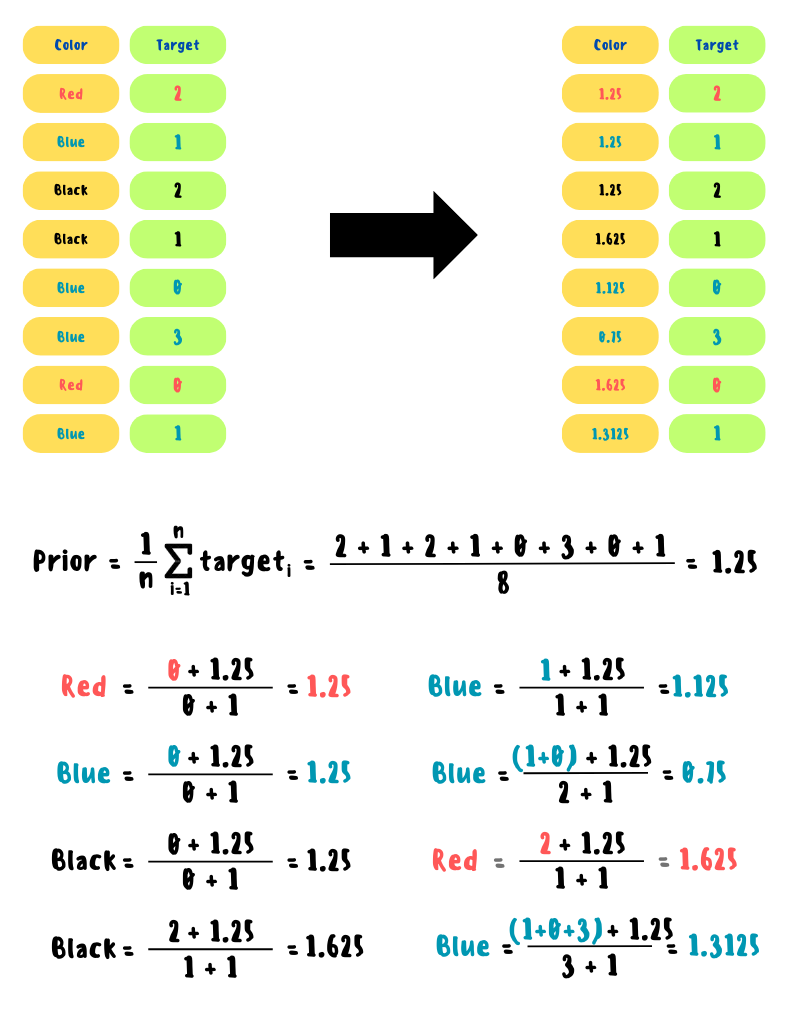

In [16]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [17]:
from category_encoders.cat_boost import CatBoostEncoder

train = pd.DataFrame({"color": ["red", "blue", "black", "black", "blue", "blue", "red", "blue"]})
target = pd.Series([2, 1, 2, 1, 0, 3, 0, 1])

cbe_encoder = CatBoostEncoder()
train_cbe = cbe_encoder.fit_transform(train, target)
prior = target.mean()

print(f'prior: {prior}', '', sep='\n')
print(train_cbe)

prior: 1.25

    color
0  1.2500
1  1.2500
2  1.2500
3  1.6250
4  1.1250
5  0.7500
6  1.6250
7  1.3125


In the case of float features a set of labels is created using quantization and their binarization is performed into k classes: all values before the boundary (labels) belong to class 0 and after that to class 1. Next, the procedure is similar to the case of multiclassification.

The following types of quantization are supported in CatBoost:
- mode;
- median grid;
- uniform grid + quantiles (the quantization size is halved and the partitions (thresholds) are combined in one of two ways: median or uniform grid);
- MaxLogSum — maximizes the value of the following expression within each segment:
$\sum\limits_{i=1}^{n} log \ w_i$
- MinEntropy — the value of the following expression is minimized inside each segment:
$\sum\limits_{i=1}^{n} w_i \ log \ w_i$
- GreedyLogSum — the approximation of the following expression inside each segment is maximized in a greedy way:
$\sum\limits_{i=1}^{n} log \ w_i$

$\ \ \ \ $ where n is the number of different objects in the segment, w (weight) is the number of repetitions of the object in the segment.

**Combination of categorical features**

CatBoost uses a combination of categorical features (for example, a red sofa, a blue sofa, a blue table, and so on), which allows the model to take into account the non-obvious relationships between them and improve the quality of the final predictions in general. To avoid exponential growth of combinations of categorical features their creation does not occur before the start of training but at the time of building each tree by a greedy algorithm separately.

### **The structure of decision trees and ordered boosting**
Symmetrical one-sided trees with the same depth and width are used as basic models in CatBoost. The developers of the algorithm believe that this approach allows you to speed up training and create trees that are less susceptible to overfitting.

To find the best partitioning criterion in a node cosine similarity is used and its maximum value will correspond to the best criterion:

$$Cosine \ Similarity = \frac{ \sum\limits_{i=1}^{n} A_i B_i}{\sqrt{\sum\limits_{i=1}^{n} A_i^2}
\sqrt{\sum\limits_{i=1}^{n} B_i^2}}$$
where A is a vector with residual errors, B is a vector with predictions in leaf nodes.

The problem with classical boosting is that the predictions of the basic models can have a high bias which ultimately leads to overfitting of the model in general. This is due to the fact that the training and evaluation of trees are performed on the same data set (X_train). This problem is solved using the linear approximation method of Ordered Boosting, the essence of which is as follows: the data is randomly mixed and after which the current tree is trained on m-1 samples, taking into account the remnants of the previous one which is very similar to the principle in ordered target encoding, that is, initially one sample is taken from the dataset and the model is training from all the samples before it, that is, on zeros and then two samples are taken and the model is training from one, after which the residuals are calculated which will be used for the next model and so on. This approach allows you to train a tree with complexity O(log(m)) instead of O(m$^2$).

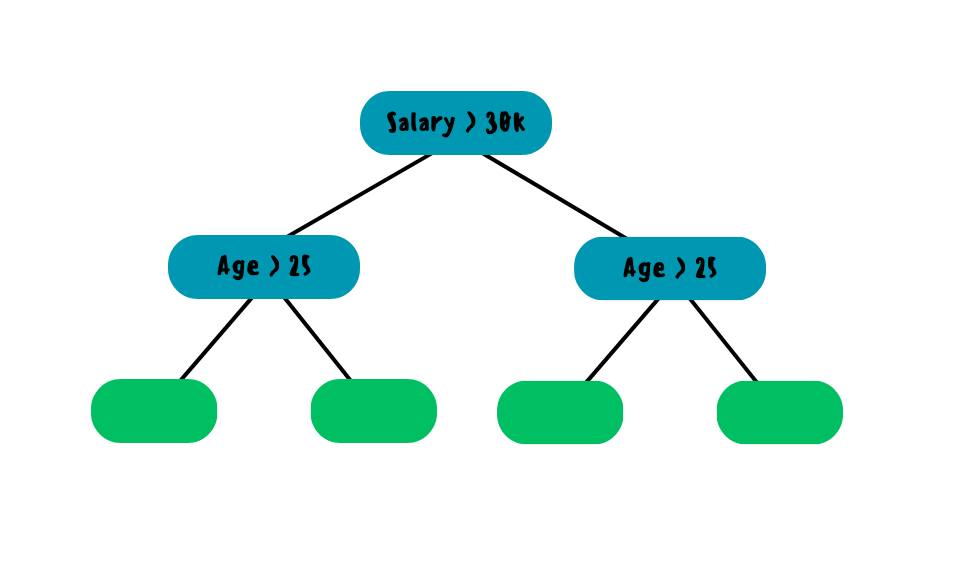

### **Additional features of CatBoost**
**Working with skips**

The following skip processing modes are supported:
- "Forbidden" — skips are interpreted as errors.
- "Min" — skips are treated as the minimum value (less than all other values) for the object.
- "Max" — skips are treated as the maximum value (exceeding all other values) for the object.

The default processing mode is Min. Also when choosing trees the partitioning is taken into account separating the missing values from all the others.

**Snapshots**

This parameter (save_snapshot=True) allows you to create backups of intermediate results. If an unexpected interruption of learning occurs (for example, an accidental shutdown of the computer), then it can be continued from the saved state and in this case it is not necessary to repeat the completed iterations of tree construction.

**GPU training**

In CatBoost training is possible not only on several GPUs but also on several GPU servers at once what actually allows you to run distributed training and use datasets of any size. This procedure allows you to significantly speed up the algorithm: the larger the dataset, the greater the performance gain compared to CPU training. In order to use this, it is enough to specify task_type="GPU".

### **Package implementation of CatBoost and evaluation of the obtained results**
As you can see from the classification example, despite the large number of improvements CatBoost doesn't always show high results in comparison with other implementations of gradient boosting, as its developers claim. The difference is especially noticeable in the case of unbalanced datasets. However, it is worth noting that in the case of good data preparation, all other things being equal in some cases CatBoost will differ from other modifications with slightly higher accuracy.

In the case of regression when there is no obvious problem as in the case above, CatBoost copes quite well.

The results are shown below.

In [18]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00


**CatBoostClassifier**

cb_clf accuracy: 0.6851851851851852
[5 0 1 4 1 1 0 1 1 1 0 0 1 1 1 5 2 1 2 2 1 0 5 1 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 1 5 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


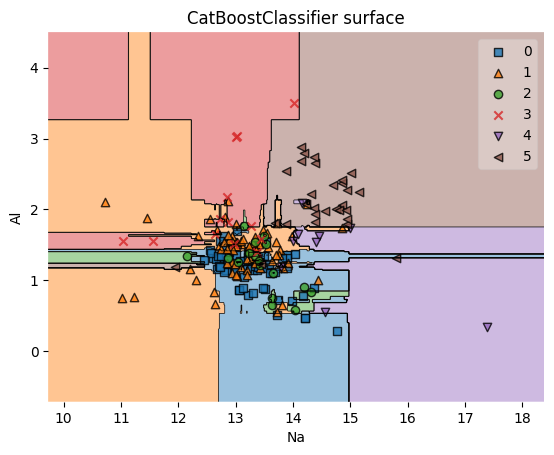

In [19]:
from catboost import CatBoostClassifier, CatBoostRegressor

cb_clf = CatBoostClassifier(random_seed=0, logging_level='Silent')
cb_clf.fit(X1_train, y1_train)
cb_clf_pred_res = cb_clf.predict(X1_test).squeeze()   # remove all single-dimensional entries
cb_clf_accuracy = accuracy_score(y1_test, cb_clf_pred_res)
print(f'cb_clf accuracy: {cb_clf_accuracy}')
print(cb_clf_pred_res)

feature_indexes = [1, 3]
title3 = 'CatBoostClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, cb_clf, feature_indexes, title3)

**CatBoostRegressor**

In [20]:
cb_reg = CatBoostRegressor(random_seed=0, logging_level='Silent')
cb_reg.fit(X2_train, y2_train)
cb_reg_pred_res = cb_reg.predict(X2_test)
cb_reg_mape = mean_absolute_percentage_error(y2_test, cb_reg_pred_res)
print(f'cb_reg mape: {cb_reg_mape}')
print(cb_reg_pred_res)

cb_reg mape: 0.39538306365546094
[268.21698587 226.61112865 152.56164473 105.39534082 185.56084388
 231.13386917 112.94031582 246.11217136 121.83631454 238.66069067
 193.92810529 171.53207065 120.95427566  98.87431921 301.0159263
  97.989809   170.68360243  70.03044356 104.9534818  235.1624283
 174.7895105  131.39173163 178.28683674 128.13631321 230.60611298
 186.37090017 131.52230822  61.453026   231.95028492 148.67901568
 186.2317954   80.45908918 137.68617262 171.24445717 128.77648933
 178.31364898 179.17236177 149.82094832 102.25676058 209.48231728
 116.01443961 169.06621701 110.9047463  210.24240477 158.28102362
  72.4532758  135.86931928 121.14865532  76.8103627  278.66222581
 127.85077736  55.25704176 144.51194393 170.06468442 271.51905928
 187.61879537 159.56680649 118.65520621 121.92004997 183.56316238
 248.87847858 137.77180529 117.98743897  82.53109543 255.59388802
 151.23062005  94.00606836 257.15481144 227.21705762  96.77322241
  78.34198817 118.09701594  91.2069645   91.7

### **Pros and cons of CatBoost**
Pros:
- high accuracy and training speed in most cases;
- the ability to work with categorical features;
- a large number of hyperparameters for configuring the algorithm;
- used for many tasks.

Cons:
- unstable work with unbalanced data;
- complexity in configuration due to the large number of hyperparameters;
- nasty documentation (personal opinion).

### **Additional sources**
Paper «CatBoost: unbiased boosting with categorical features», Liudmila Prokhorenkova, Gleb Gusev, Aleksandr Vorobev, Anna Veronika Dorogush, Andrey Gulin.

[Documentation](https://catboost.ai/en/docs/).

[Lecture](https://www.youtube.com/watch?v=UYDwhuyWYSo&t=1281s&ab_channel=ComputerScienceCenter).

Step-by-step construction of CatBoost (ordered target encoding has errors):
- [one](https://www.youtube.com/watch?v=KXOTSkPL2X4&t=447s&ab_channel=StatQuestwithJoshStarmer);
- [two](https://www.youtube.com/watch?v=3Bg2XRFOTzg&ab_channel=StatQuestwithJoshStarmer).


## **LightGBM features**
LightGBM (Light Gradient Boosting Machine) is an implementation of gradient boosting from Microsoft, capable of processing large datasets and at the same time providing high accuracy. Let's take a closer look at the key features that influenced this.

### **Gradient-based One-Side Sampling (GOSS)**
Unlike classical gradient boosting where regression trees are trained on the entire X_train set, in LightGBM trees are trained on a subset of data obtained using Gradient-based One-Side Sampling (GOSS), the essence of which is to sort and select top N samples with the largest gradient. This means that it is these data that should be given special attention because the tree will make the most mistakes on them. In addition, a part of the samples with a low gradient is randomly selected, followed by assigning them weights $\frac{1-a}{b}$ in order to avoid changes in the distribution of data.

$a$ is the percentage of top N samples with the highest gradient, $b$ is the percentage of samples with a low gradient.

In simple terms, using GOSS allows you to significantly speed up the training of each subsequent tree in the ensemble by reducing the train dataset without much loss in the quality of predictions in most cases.

### **Histogram-based tree node splitting**
When searching for the best node partitioning criterion in LightGBM you can also use a histogram of feature values: all threshold values of the histogram are iterated over instead of all feature values which allows you to significantly speed up the search for the best criterion. For example, for the "height" attribute, you can use the questions "height" 160, "height" 170 instead of "height" 163, "height" 167 and so on.
As you can see, histograms are used in one form or another in all three modifications of gradient boosting.

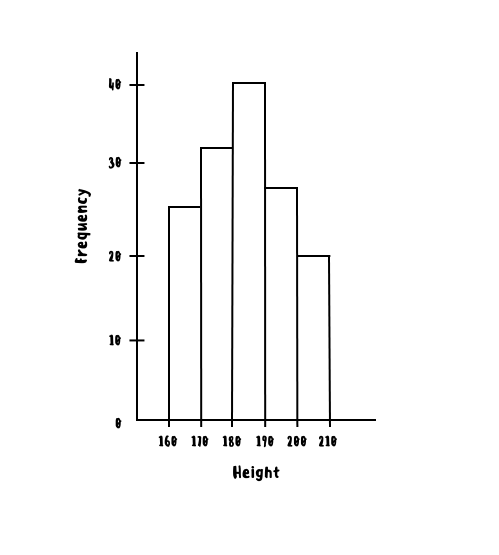

### **Exclusive Feature Bundling (EFB)**
Let's assume that in one way or another there are encoded categorical features in the dataset, most of which are mutually exclusive (those that do not simultaneously take non-zero values). With a large number of such features model training may take too long and to solve this problem LightGBM uses reducing the dimension of the feature space with Exclusive Feature Bundling (EFB).

It is worth noting that, in fact, strictly mutually exclusive features in the data are extremely rare. Therefore such a concept is introduced as the proportion of conflicts between signs — the ratio of observations from the total number, where two features take non-zero values at the same time.

Let's say there is a dataset with the features $F_0 - F_4$. First of all, it is necessary to set an acceptable proportion of conflicts, for example, 25%. Then, in the case of 8 samples the permissible number of conflicts will be 2. Next, a matrix of conflicts between all features is built and the total amount of conflicts for each sign is calculated after which they are sorted in descending order.

Based on the conflict matrix, a weighted graph is constructed in which all edges with a number of conflicts exceeding the allowed value are cut off in the resulting order.

**Working with Exclusive Feature Bundling from scratch using a simple example**

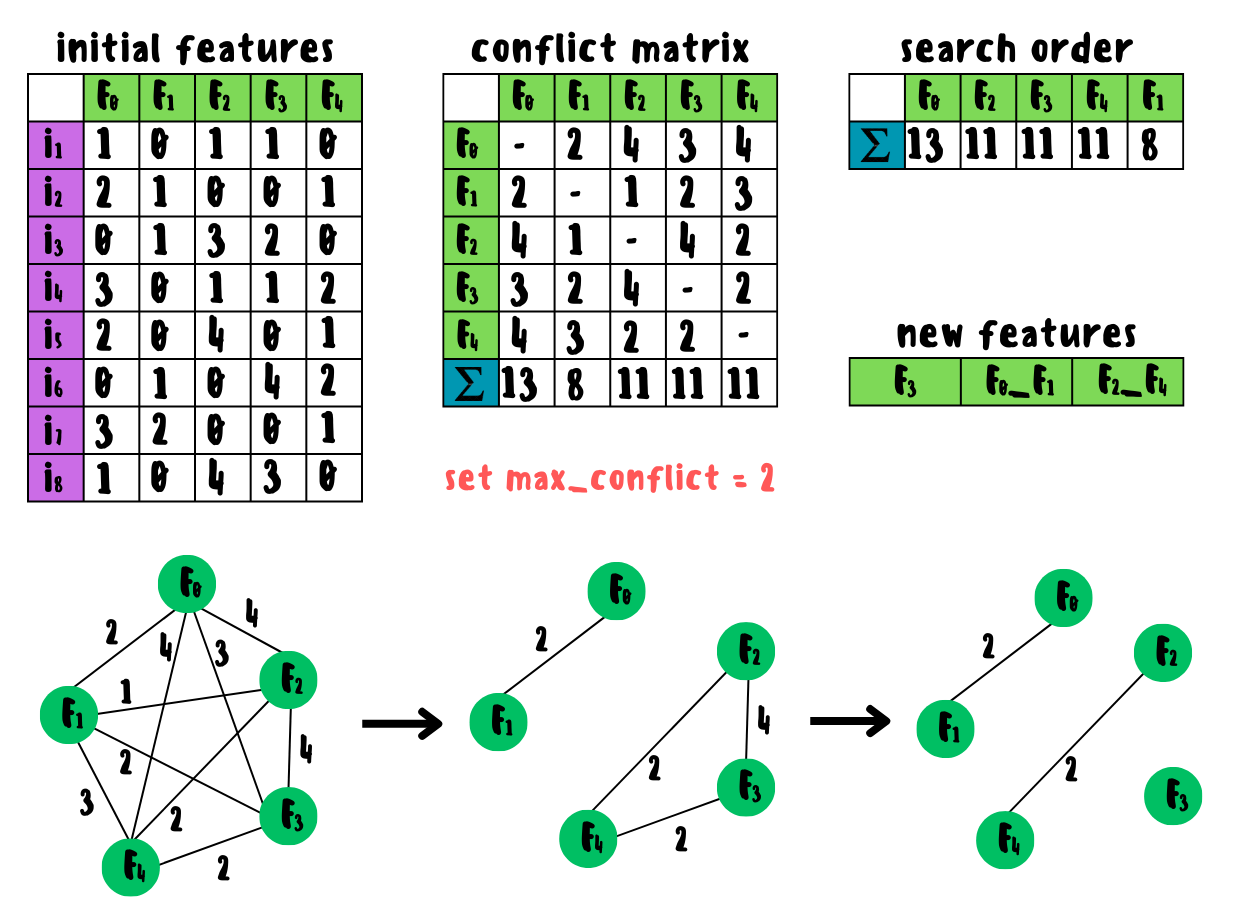

The first bundle will be $F_0 - F_1$. Despite the fact that $F_1 - F_2$ and $F_1 - F_3$ do not conflict, their union is impossible due to conflicts $F_0 - F_2$ and $F_0 - F_3$. The next bundle will be $F_2 - F_4$. Despite the fact that $F_4$ and $F_3$ do not conflict, their union is impossible due to the conflict $F_2 - F_3$. The last feature is $F_3$.

The new bundle will consist of non-zero values of the first feature and non-zero values of the second one plus an offset equal to the maximum value of the first feature: the offset of each subsequent feature will be equal to the sum of the maximum values of the previous ones. In cases where there is a conflict the value of the last feature with an offset is taken.

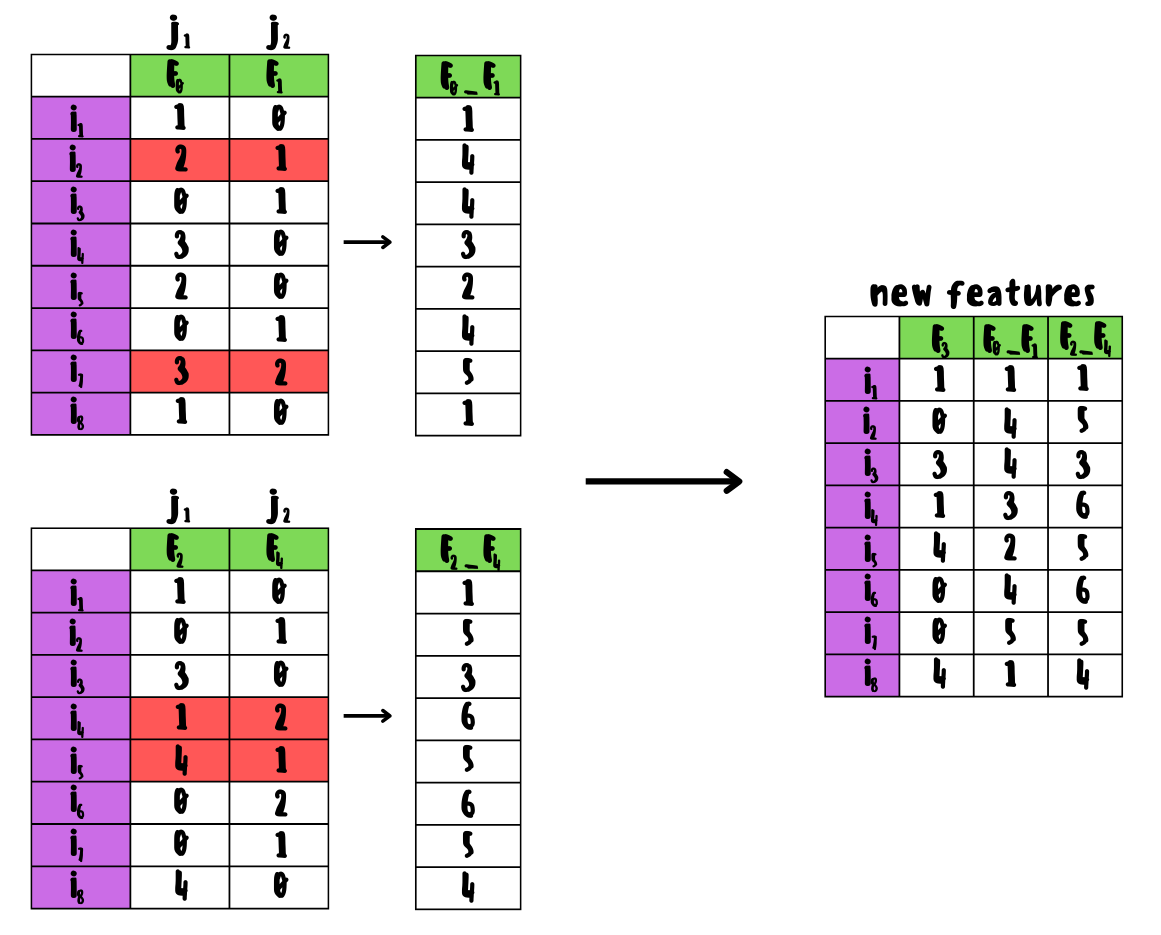

Detailed calculations are given below.

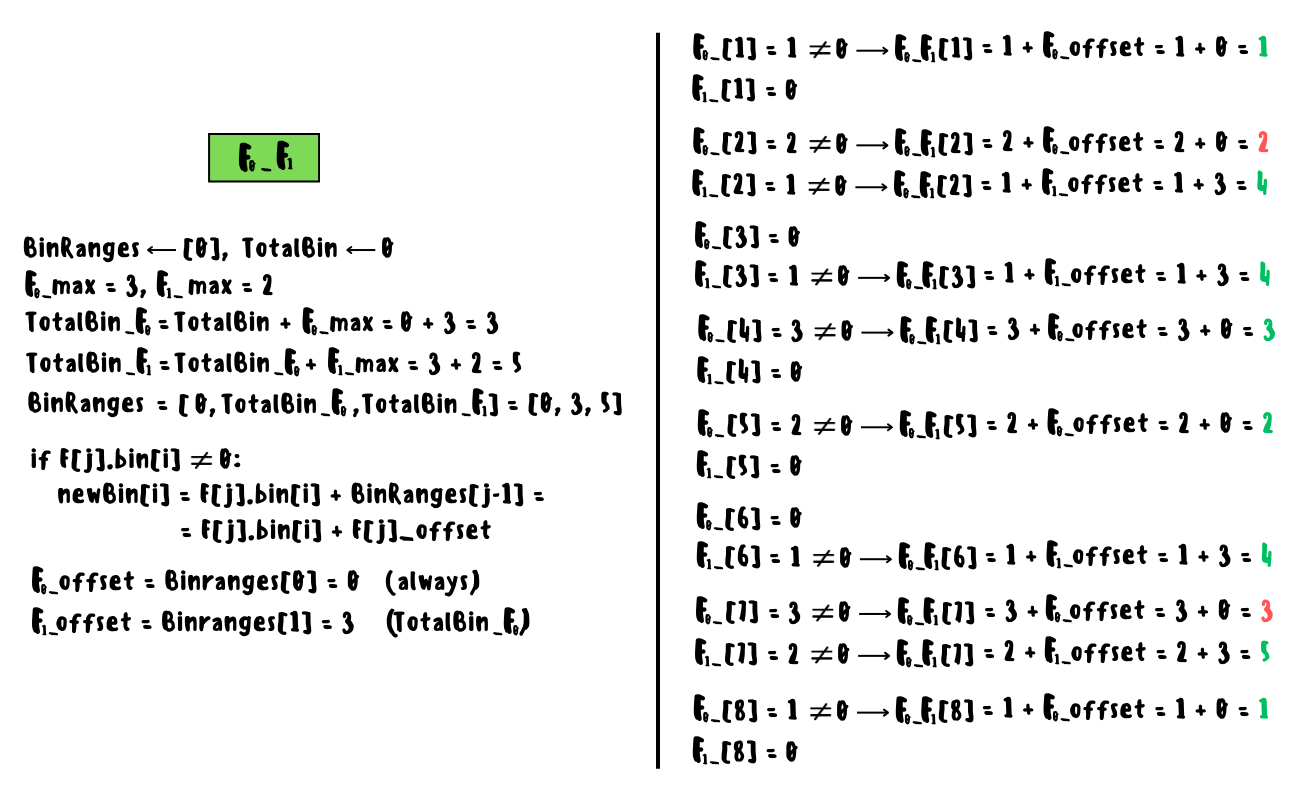

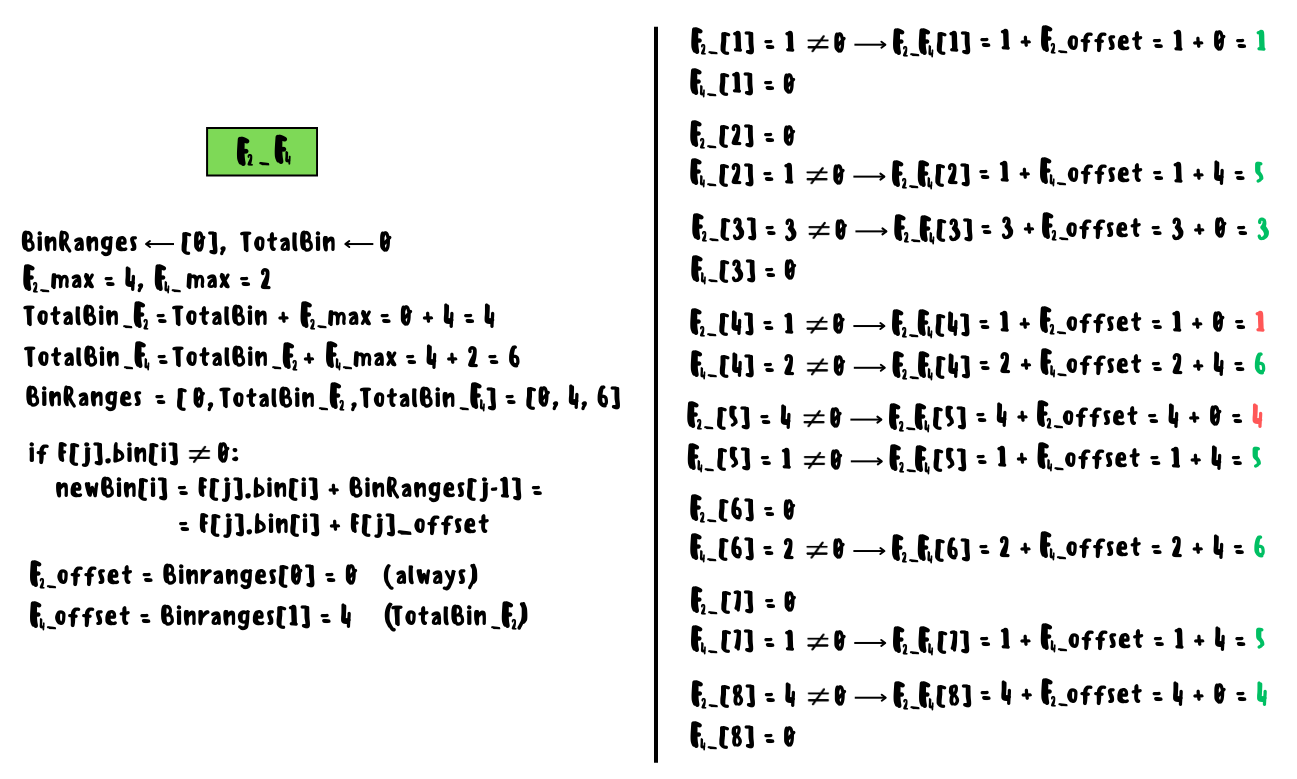

It is easy to see that the EFB algorithm can be optimized by ignoring calculations for all zero values in the features. This optimization can also be applied to *histogram-based tree node splitting* which generally reduces the complexity of constructing a histogram from O(data) to O(non-zero data).

### **Leaf-wise tree growth**
Instead of building trees layer by layer, in LightGBM trees are built in depth: growth continues in the leaf node with the greatest information gain, as a result of which the tree turns out to be deep and asymmetrical. Most often this approach is superior to symmetric trees in terms of accuracy.

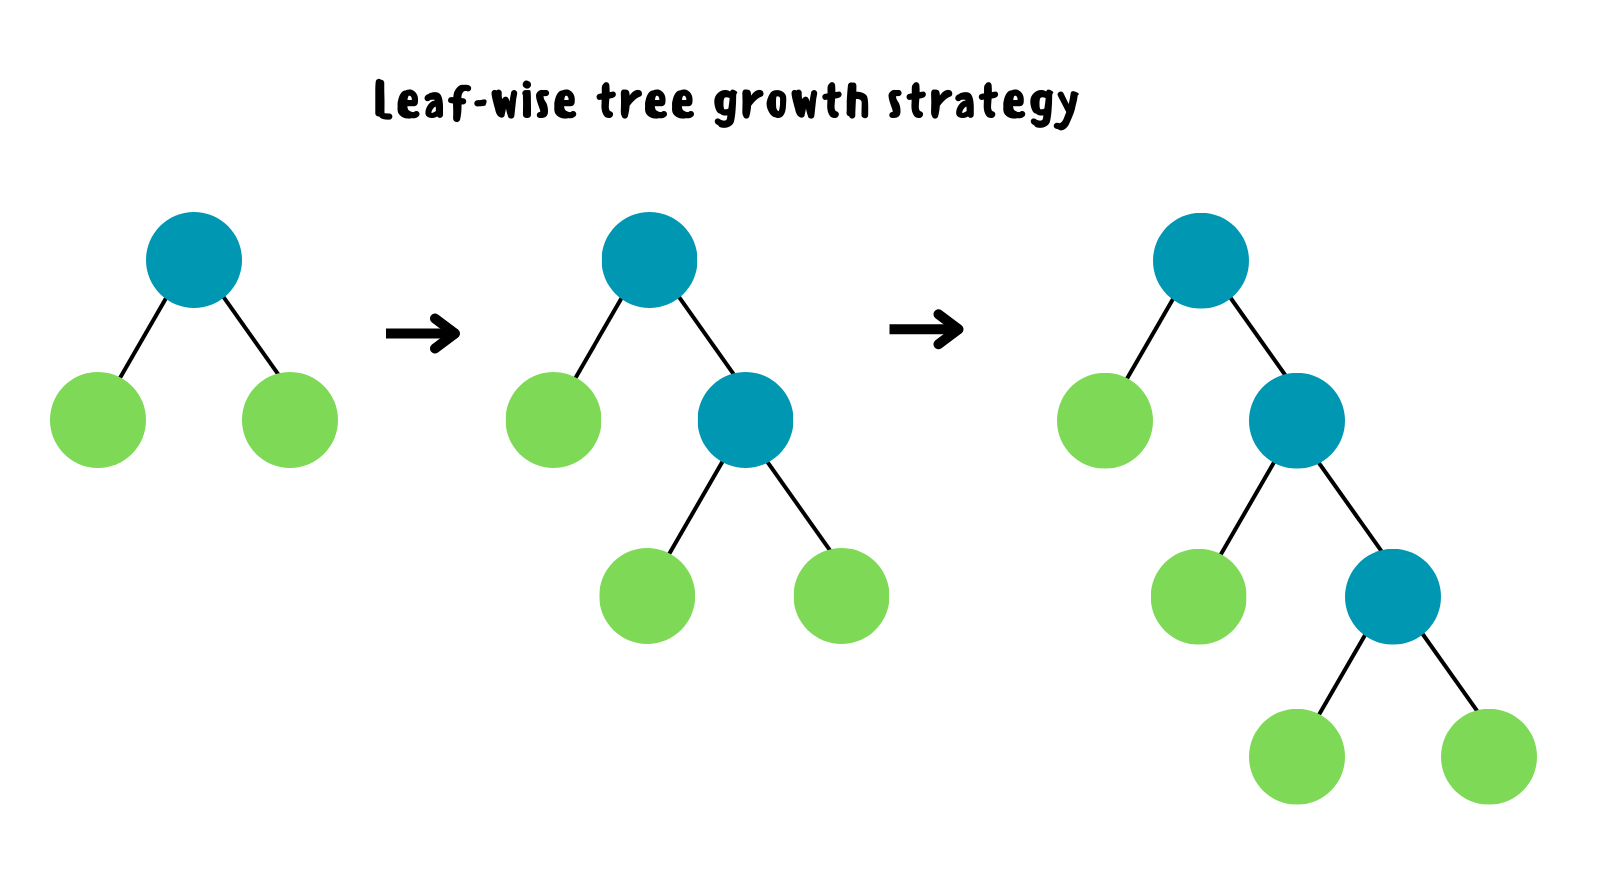

### **GPU Training**
When working with large datasets LightGBM supports training not only on the GPU but also distributed training on several machines at once.

At the moment there are the following approaches:

- Data parallel (dataset samples are divided into local histograms, each of which is processed separately);
- Feature parallel (dataset features are divided into local histograms, each of which is processed separately);
- Voting parallel (at each process the K best features are locally selected for splitting after which the best one is selected globally).

### **Package implementation of LightGBM and evaluation of the obtained results**
As you can see, in the case of classification LightGBM showed the result out of the box much better than previous boosting modifications. It is also worth noting that of all three considered modifications of gradient boosting LightGBM is the fastest: the larger the dataset, the more noticeable the difference in terms of speed will be.

The results are shown below.

**LGBMClassifier**

lgb_clf accuracy: 0.7407407407407407
[5 0 1 4 1 1 0 1 1 1 0 0 0 1 1 5 2 1 2 2 3 1 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 1 4 1 0 0 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


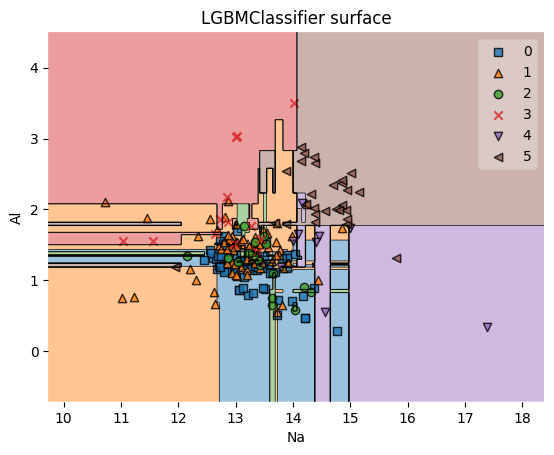

In [21]:
from lightgbm import LGBMClassifier, LGBMRegressor

lgb_clf = LGBMClassifier(random_state=0, verbose=-1)
lgb_clf.fit(X1_train, y1_train)
lgb_clf_pred_res = lgb_clf.predict(X1_test)
lgb_clf_accuracy = accuracy_score(y1_test, lgb_clf_pred_res)
print(f'lgb_clf accuracy: {lgb_clf_accuracy}')
print(lgb_clf_pred_res)

feature_indexes = [1, 3]
title4 = 'LGBMClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, lgb_clf, feature_indexes, title4)

**LGBMRegressor**

In [22]:
lgb_reg = LGBMRegressor(random_state=0, verbose=-1)
lgb_reg.fit(X2_train, y2_train)
lgb_reg_pred_res = lgb_reg.predict(X2_test)
lgb_reg_mape = mean_absolute_percentage_error(y2_test, lgb_reg_pred_res)
print(f'lgb_reg_mape: {lgb_reg_mape}')
print(lgb_reg_pred_res)

lgb_reg_mape: 0.39864113147931
[261.46864967 223.24674049 179.60231224 104.76984808 197.67529058
 264.26116883 111.11355079 243.72059654 144.18045853 239.08131542
 199.90841705 170.37417433 151.67933516  89.30779664 297.93561211
  96.58862229 162.53285879  70.06113305 108.36436227 234.16276627
 207.7552967  136.83913826 172.38724529 110.26981866 228.1574526
 163.56817258 108.94516511  73.93303203 233.31869769 116.00042252
 195.39846082  72.54403358 164.38943926 194.42418913 130.42154381
 183.04435501 173.56352142 147.00774306  89.07365731 175.25759644
 108.72749406 144.48000593  99.60713604 196.86889512 160.47835096
  60.17798032 133.4909559  115.46543242  64.48286456 251.20520649
 135.52608509  45.16396653 161.70420785 187.28406745 274.21158331
 179.30355071 150.1563969  111.1275583  100.5067047  133.7868607
 269.98464504 159.03980859 118.01578638  75.41625416 249.0569831
 133.99026562 111.43954756 221.81954307 206.02676942  81.56098377
  72.5920367  101.31664062  93.31261471 111.2448

### **Pros and cons of LightGBM**
Pros:
- high accuracy of predictions and especially the training speed;
- the ability to work with categorical features;
- a large number of hyperparameters for configuring the algorithm;
- used for many tasks.

Cons:
- unstable operation on small datasets is possible;
- configuration complexity due to the large number of hyperparameters.

### **Additional sources**
Paper «LightGBM: A Highly Efficient Gradient Boosting Decision Tree», Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu.

[Documentation](https://lightgbm.readthedocs.io/en/latest/index.html).

Lectures:
- [one](https://www.youtube.com/watch?v=NH0ozgXjrzk&t=304s&ab_channel=%D0%A6%D0%B5%D0%BD%D1%82%D1%80digital%D0%BF%D1%80%D0%BE%D1%84%D0%B5%D1%81%D1%81%D0%B8%D0%B9ITtensive);
- [two](https://www.youtube.com/watch?v=qGsHlvE8KZM&ab_channel=PyData);
- [three](https://www.youtube.com/watch?v=E1-FFzKuDgY&list=PLgaemU2xZlTgJhfBHnolmS-8WwsFifnFn&index=2&ab_channel=meanxai);
- [four](https://www.youtube.com/watch?v=fU_X_c1W3r4&list=PLgaemU2xZlTgJhfBHnolmS-8WwsFifnFn&index=1&ab_channel=meanxai).

## **Which boosting is better**
There is no clear answer to the question of which boosting is better. If earlier it could be said that when working with categorical features it is better to use CatBoost, when speed is important — LightGBM, or XGBoost if you want a stable solution and there is no time for experiments, now a such statement will be incorrect: as you could see, all three modifications managed to copy a lot of good ideas from each other but historically they have differed quite a lot.

It would be more correct to say that the choice of the best boosting will depend on the specific task and the data that are used to train the model: in different scenarios the same algorithms can show both the best results in terms of speed and accuracy, and vice versa the worst. Thus, the choice of the most optimal boosting algorithm will consist in conducting experiments with different modifications and comparing the results obtained.

### **Several useful sources with boostings comparison**
[One](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm), [two](https://www.kaggle.com/code/faressayah/xgboost-vs-lightgbm-vs-catboost-vs-adaboost), [three](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc).